In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import torch
import matplotlib.colors as mcolors
from tqdm import tqdm

# Add parent directory to system path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core and utils directory 
from algorithms import OnlineMA, OnlineMARegret, OnlineMC, OnlineMCAdaptive
from utils import rolling_mean, rolling_vec_norm

In [6]:
# Load the COMPAS dataset (adapted from https://github.com/aangelopoulos/gradient-equilibrium/blob/main/compas/debias.ipynb)
df = pd.read_csv('./raw_data/compas-scores-two-years.csv')
df = df[['compas_screening_date', 'sex', 'race', 'v_decile_score', 'is_recid']]
df = df[df.race.isin(["African-American", "Caucasian", "Hispanic"])]
df.compas_screening_date = pd.to_datetime(df.compas_screening_date)

# drop rows after 2014-04-01 (keep rows on or before this date)
cutoff = pd.Timestamp('2014-04-01')
df = df[df.compas_screening_date <= cutoff]

df_req = df.sort_values(by='compas_screening_date', ignore_index=True)
df_req['compas_screening_date'] = pd.to_datetime(df_req['compas_screening_date'])
df_req = df_req.set_index('compas_screening_date')

df_req['p_tilde'] = df_req['v_decile_score'] / 10.0


Plotting moving averages:
African-American: plotting 3139 points from 2013-01-01 to 2014-04-01
Caucasian: plotting 2132 points from 2013-01-01 to 2014-04-01
Hispanic: plotting 563 points from 2013-01-01 to 2014-04-01


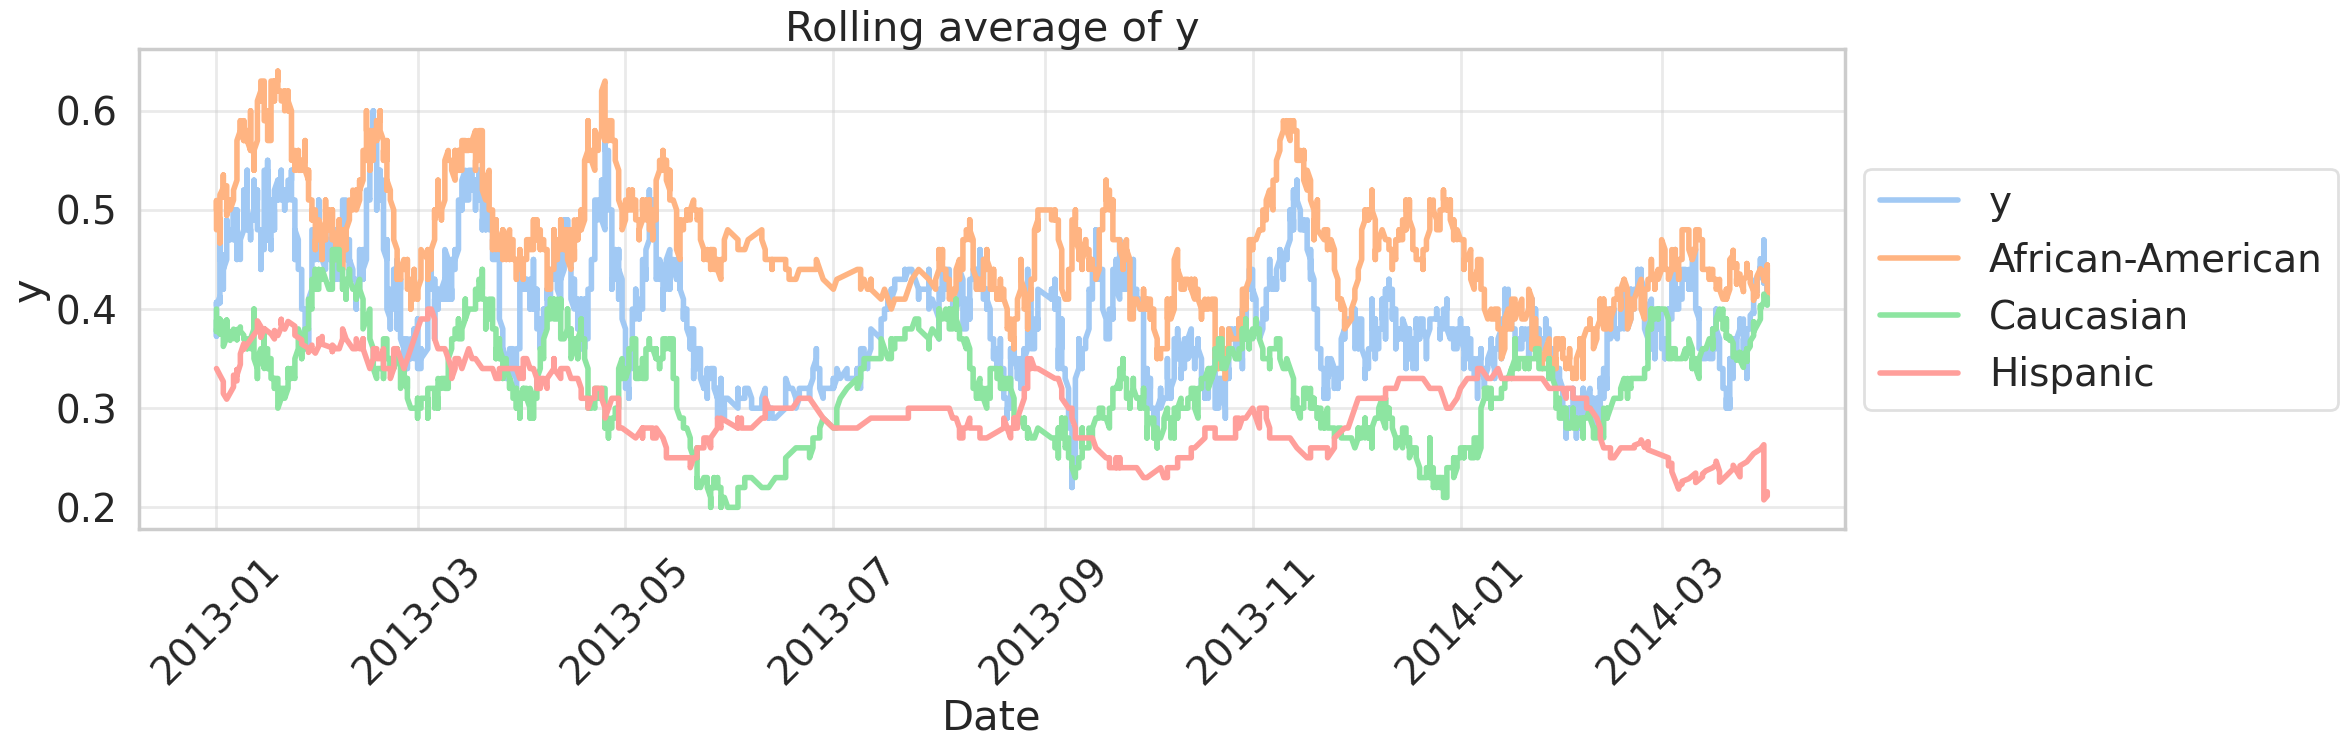

In [19]:
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("pastel")

print(f"\nPlotting moving averages:")
fig, ax = plt.subplots(figsize=(24, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Plot moving averages for all race groups
window_size = 100

# Plot y moving averages
y = df_req['is_recid'].astype(float)
y_ma = y.rolling(window=window_size, center=True, min_periods=1).mean()
ax.plot(y_ma.index, y_ma.values, linewidth=4, label=f"y")

# Per-race moving averages
races = df_req['race'].astype('category')
order = list(races.cat.categories)
df_moving_avg_by_race = []

for race in order:
    race_data = df_req[df_req['race'] == race].copy()

    if len(race_data) < 1:
        print(f"Warning: {race} has only {len(race_data)} observations, skipping.")
        continue

    race_data['moving_avg'] = (race_data['is_recid'].astype(float).rolling(window=window_size, center=True, min_periods=1).mean())
    
    race_data = race_data.reset_index()  # restore 'compas_screening_date' as column
    df_moving_avg_by_race.append(race_data)

    # Drop NaNs and plot
    race_df_clean = race_data.dropna(subset=['moving_avg'])
    start = race_df_clean['compas_screening_date'].min().strftime('%Y-%m-%d')
    end   = race_df_clean['compas_screening_date'].max().strftime('%Y-%m-%d')
    npts  = len(race_df_clean)

    print(f"{race}: plotting {npts} points from {start} to {end}")

    ax.plot(race_df_clean['compas_screening_date'], race_df_clean['moving_avg'], linewidth=4, label=f"{race}")

ax.set_xlabel("Date", fontsize=30)
ax.set_ylabel("y", fontsize=30)
ax.set_title("Rolling average of y", fontsize=30)
ax.tick_params(axis="x", rotation=45, labelsize=28)
ax.tick_params(axis="y", labelsize=28)

fig.subplots_adjust(right=0.9)  # make room on the right for the legend
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=True, framealpha=0.6, ncol=1, fontsize=28)

ax.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()




Plotting moving averages:
African-American: plotting 3139 points from 2013-01-01 to 2014-04-01
Caucasian: plotting 2132 points from 2013-01-01 to 2014-04-01
Hispanic: plotting 563 points from 2013-01-01 to 2014-04-01


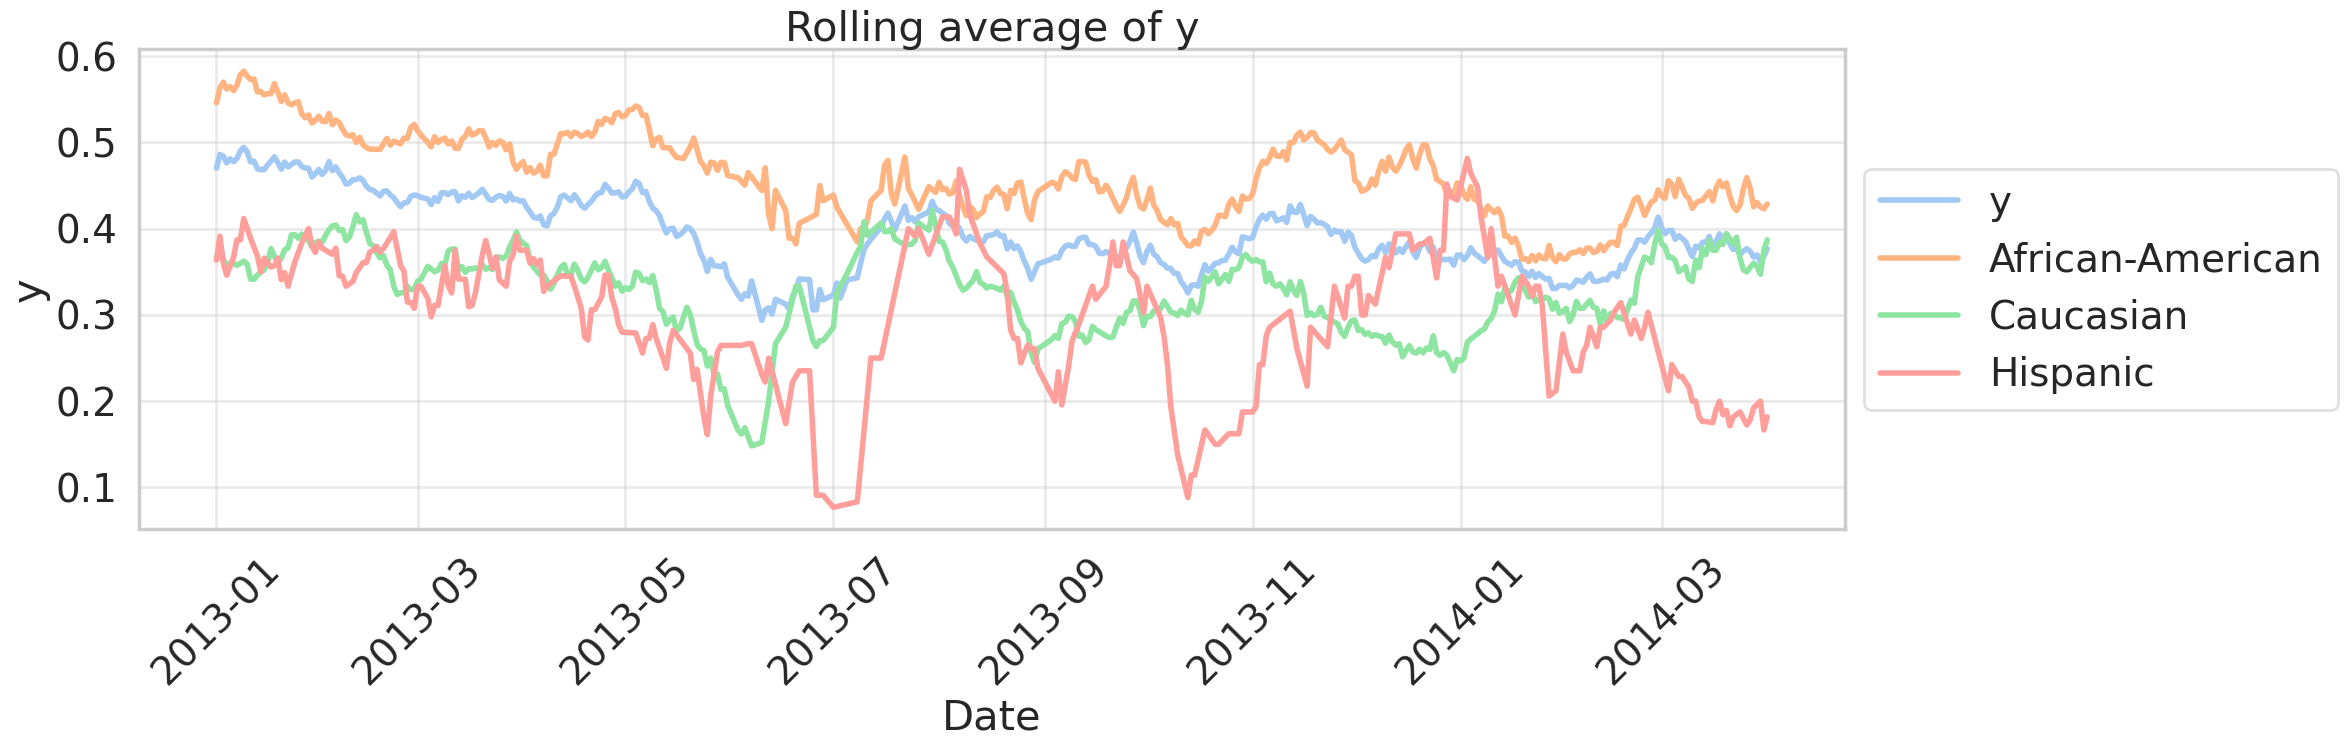

In [20]:
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("pastel")

print(f"\nPlotting moving averages:")
fig, ax = plt.subplots(figsize=(24, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Plot moving averages for all race groups
window_size = "30D"

# Plot y moving averages
y = df_req['is_recid'].astype(float)
y_ma = y.rolling(window=window_size, center=True, min_periods=1).mean()
ax.plot(y_ma.index, y_ma.values, linewidth=4, label=f"y")

# Per-race moving averages
races = df_req['race'].astype('category')
order = list(races.cat.categories)
df_moving_avg_by_race = []

for race in order:
    race_data = df_req[df_req['race'] == race].copy()

    if len(race_data) < 1:
        print(f"Warning: {race} has only {len(race_data)} observations, skipping.")
        continue

    race_data['moving_avg'] = (race_data['is_recid'].astype(float).rolling(window=window_size, center=True, min_periods=1).mean())
    
    race_data = race_data.reset_index()  # restore 'compas_screening_date' as column
    df_moving_avg_by_race.append(race_data)

    # Drop NaNs and plot
    race_df_clean = race_data.dropna(subset=['moving_avg'])
    start = race_df_clean['compas_screening_date'].min().strftime('%Y-%m-%d')
    end   = race_df_clean['compas_screening_date'].max().strftime('%Y-%m-%d')
    npts  = len(race_df_clean)

    print(f"{race}: plotting {npts} points from {start} to {end}")

    ax.plot(race_df_clean['compas_screening_date'], race_df_clean['moving_avg'], linewidth=4, label=f"{race}")

ax.set_xlabel("Date", fontsize=30)
ax.set_ylabel("y", fontsize=30)
ax.set_title("Rolling average of y", fontsize=30)
ax.tick_params(axis="x", rotation=45, labelsize=28)
ax.tick_params(axis="y", labelsize=28)

fig.subplots_adjust(right=0.9)  # make room on the right for the legend
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=True, framealpha=0.6, ncol=1, fontsize=28)

ax.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

